# Internet Speed and Conflict

In [2]:
%reload_ext autoreload
%autoreload 2

import geopandas as gpd
import pandas as pd
import glob

from internet_visuals import *


In [3]:
internet = gpd.GeoDataFrame()
for file in glob.glob('../../data/internet/gdf_*_with_variables.gpkg'):
    country_name = file.split('_')[1].split('_')[0]
    df = gpd.read_file(file)
    df['country'] = country_name
    internet = pd.concat([internet, df])


In [4]:
conflict = pd.read_csv('../../data/conflict/conflict_quad12_regional_quarterly.csv')

In [5]:
df = internet

# Get download speed columns
download_cols = [col for col in df.columns if col.startswith('avg_download_')]

# Melt the dataframe
df_melted = df.melt(
   id_vars=['index', 'population', 'geometry', 'country'],
   value_vars=download_cols,
   var_name='period',
   value_name='download_speed'
)

# Extract year and quarter, create date
df_melted['year'] = df_melted['period'].str.extract(r'(\d{4})').astype(int)
df_melted['quarter'] = df_melted['period'].str.extract(r'_(\d)$').astype(int)

# Create quarterly date (first day of quarter)
df_melted['date'] = pd.to_datetime(
   df_melted['year'].astype(str) + '-' + 
   ((df_melted['quarter'] - 1) * 3 + 1).astype(str) + '-01'
)

# Clean up - drop intermediate columns
df_final = df_melted.drop(['period', 'year', 'quarter'], axis=1)

In [6]:
internet = df_final[df_final['date']>='2022-01-01']

In [7]:
import pycountry

def get_iso_code_from_country_name(country_name: str) -> str | None:
    """
    Returns the 3-letter ISO code for a given country name using the pycountry library.

    Args:
        country_name (str): The common name of the country (e.g., "United States", "Canada").

    Returns:
        str | None: The 3-letter ISO code (e.g., "USA") if found, otherwise None.
    """
    try:
        country = pycountry.countries.search_fuzzy(country_name)
        if country:
            return country[0].alpha_3
        return None
    except LookupError:
        return None
    except Exception as e:
        logger.error(f"An error occurred while looking up ISO code for '{country_name}': {e}")
        return None

In [8]:
country_code = conflict[['country']].drop_duplicates()
country_code.rename(columns={'country':'country_name'}, inplace=True)
country_code['country'] = country_code['country_name'].apply(lambda x: get_iso_code_from_country_name(x))

In [9]:
country_code = country_code.set_index('country_name').to_dict()['country']

In [10]:
conflict['country'] = conflict['country'].map(country_code)

In [11]:
conflict.drop(columns=['level_0', 'Unnamed: 0'], inplace=True)
conflict['index'] = conflict['index'].astype('int')
conflict['event_date'] = pd.to_datetime(conflict['event_date'])

In [12]:
internet['index'] = internet['index'].astype('int')

c:\WBG\Anaconda3\envs\acled\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
conflict.rename(columns={'event_date':'date'}, inplace=True)

In [14]:
merged = internet.merge(conflict, on =['index', 'country', 'date'])[['date','index', 'population', 'country', 'download_speed', 'conflict_intensity_index', 'nrFatalities', 'nrEvents']]

In [15]:
from acled_conflict_analysis import processing
national_merged = merged.groupby(['country', 'date']).agg({
    'download_speed':'mean',
    'nrFatalities':'sum',
    'nrEvents':'sum'
}).reset_index()

national_merged = processing.calculate_conflict_index(national_merged)

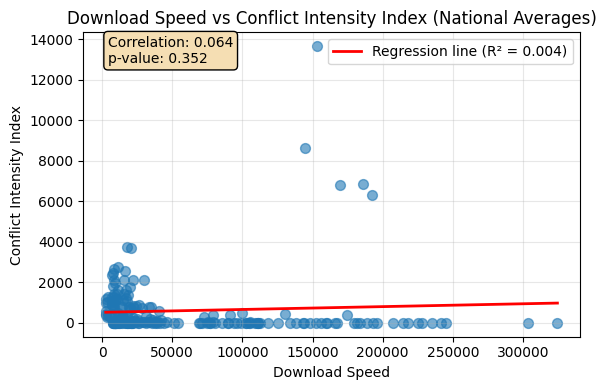

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

# Create scatter plot with regression line
plt.figure(figsize=(6, 4))

# Scatter plot
plt.scatter(national_merged['download_speed'], national_merged['conflict_intensity_index'], 
           alpha=0.6, s=50)

# Calculate regression line using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(
    national_merged['download_speed'], national_merged['conflict_intensity_index']
)

# Create regression line points
x_line = np.linspace(national_merged['download_speed'].min(), 
                     national_merged['download_speed'].max(), 100)
y_line = slope * x_line + intercept

# Plot regression line
plt.plot(x_line, y_line, 'r-', linewidth=2, 
         label=f'Regression line (R² = {r_value**2:.3f})')

# Labels and formatting
plt.xlabel('Download Speed')
plt.ylabel('Conflict Intensity Index')
plt.title('Download Speed vs Conflict Intensity Index (National Averages)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add correlation info as text
plt.text(0.05, 0.9, f'Correlation: {r_value:.3f}\np-value: {p_value:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

In [83]:
from bokeh.plotting import figure, show
from bokeh.models import TabPanel, Tabs, LinearAxis, Range1d
from bokeh.layouts import column
from bokeh.io import output_notebook
import pandas as pd

def create_dual_axis_country_tab(df):
    """
    Creates a Bokeh plot with tabs for each country, showing dual-axis plots
    with conflict metrics on left axis and download speed on right axis.
    
    Args:
        df (pd.DataFrame): DataFrame with columns: 'date', 'index', 'population', 
                           'country', 'download_speed', 'conflict_intensity_index', 
                           'nrFatalities', 'nrEvents'
    
    Returns:
        Tabs: Bokeh Tabs widget with country plots
    """
    
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Get unique countries
    countries = df['country'].unique()
    
    tab_panels = []
    
    for country in countries:
        # Filter data for this country
        country_data = df[df['country'] == country].sort_values('date')
        
        if country_data.empty:
            continue
            
        # Calculate range for conflict intensity index (primary y-axis)
        conflict_min = country_data['conflict_intensity_index'].min()
        conflict_max = country_data['conflict_intensity_index'].max()
        conflict_range = conflict_max - conflict_min
        # Add padding; handle case where range is zero to prevent division by zero or too small range
        conflict_padding = conflict_range * 0.1 if conflict_range > 0 else 1 

        # Calculate range for download speed (secondary y-axis)
        download_min = country_data['download_speed'].min()
        download_max = country_data['download_speed'].max()
        download_range = download_max - download_min
        download_padding = download_range * 0.1 if download_range > 0 else 1
        
        # Create figure with left y-axis for conflict metrics, explicitly setting its range
        p = figure(
            title=f"Conflict Metrics vs Download Speed - {country}",
            x_axis_label='Date',
            y_axis_label='Conflict Intensity Index',
            x_axis_type='datetime',
            y_range=Range1d(
                start=conflict_min - conflict_padding,
                end=conflict_max + conflict_padding
            ),
            width=800,
            height=400,
            tools="pan,wheel_zoom,box_zoom,reset,save"
        )
        
        # Plot conflict intensity on left axis (primary)
        conflict_line = p.line(
            country_data['date'], 
            country_data['conflict_intensity_index'],
            line_width=2,
            color='red',
            alpha=0.8,
            legend_label='Conflict Intensity'
        )
        
        conflict_circle = p.scatter(
            country_data['date'],
            country_data['conflict_intensity_index'],
            size=6,
            color='red',
            alpha=0.6
        )
        
        # Set up right y-axis for download speed, explicitly setting its range
        p.extra_y_ranges = {
            "download": Range1d(
                start=download_min - download_padding,
                end=download_max + download_padding
            )
        }
        
        # Add right y-axis
        p.add_layout(
            LinearAxis(
                y_range_name="download",
                axis_label="Download Speed (Mbps)"
            ), 
            'right'
        )
        
        # Plot download speed on right axis
        download_line = p.line(
            country_data['date'],
            country_data['download_speed'],
            line_width=2,
            color='blue',
            alpha=0.8,
            y_range_name="download",
            legend_label='Download Speed'
        )
        
        download_circle = p.scatter(
            country_data['date'],
            country_data['download_speed'],
            size=6,
            color='blue',
            alpha=0.6,
            y_range_name="download"
        )
        
        # Customize the plot
        p.legend.location = "top_left"
        p.legend.click_policy = "hide"
        p.title.text_font_size = "14pt"
        p.xaxis.axis_label_text_font_size = "12pt"
        p.yaxis.axis_label_text_font_size = "12pt"
        
        # Add grid
        p.grid.grid_line_alpha = 0.3
        
        # Create tab panel for this country
        tab_panel = TabPanel(child=p, title=country)
        tab_panels.append(tab_panel)
    
    # Create tabs widget
    tabs = Tabs(tabs=tab_panels)
    
    return tabs

# Alternative version with fatalities instead of conflict intensity
def create_dual_axis_country_tabs_fatalities(df):
    """
    Creates a Bokeh plot with tabs for each country, showing dual-axis plots
    with fatalities on left axis and download speed on right axis.
    """
    
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Get unique countries
    countries = df['country'].unique()
    
    tab_panels = []
    
    for country in countries:
        # Filter data for this country
        country_data = df[df['country'] == country].sort_values('date')
        
        if country_data.empty:
            continue
            
        # Calculate range for fatalities (primary y-axis)
        fatalities_min = country_data['nrFatalities'].min()
        fatalities_max = country_data['nrFatalities'].max()
        fatalities_range = fatalities_max - fatalities_min
        # Add padding; handle case where range is zero
        fatalities_padding = fatalities_range * 0.1 if fatalities_range > 0 else 1 

        # Calculate range for download speed (secondary y-axis)
        download_min = country_data['download_speed'].min()
        download_max = country_data['download_speed'].max()
        download_range = download_max - download_min
        # Add padding; handle case where range is zero
        download_padding = download_range * 0.1 if download_range > 0 else 1
        
        # Create figure with explicit y_range for fatalities
        p = figure(
            title=f"Fatalities vs Download Speed - {country}", # Updated title for clarity
            x_axis_label='Date',
            y_axis_label='Fatalities', # Updated label
            x_axis_type='datetime',
            y_range=Range1d(
                start=fatalities_min - fatalities_padding,
                end=fatalities_max + fatalities_padding
            ),
            width=800,
            height=400,
            tools="pan,wheel_zoom,box_zoom,reset,save"
        )
        
        # Plot fatalities on left axis (primary)
        fatalities_line = p.line(
            country_data['date'], 
            country_data['nrFatalities'],
            line_width=2,
            color='darkred',
            alpha=0.8,
            legend_label='Fatalities'
        )
        
        fatalities_circle = p.circle(
            country_data['date'],
            country_data['nrFatalities'],
            size=6,
            color='darkred',
            alpha=0.6
        )
        
        # Set up right y-axis for download speed, explicitly setting its range
        p.extra_y_ranges = {
            "download": Range1d(
                start=download_min - download_padding,
                end=download_max + download_padding
            )
        }
        
        # Add right y-axis
        p.add_layout(
            LinearAxis(
                y_range_name="download",
                axis_label="Download Speed (Mbps)"
            ), 
            'right'
        )
        
        # Plot download speed on right axis
        download_line = p.line(
            country_data['date'],
            country_data['download_speed'],
            line_width=2,
            color='steelblue',
            alpha=0.8,
            y_range_name="download",
            legend_label='Download Speed'
        )
        
        download_circle = p.scatter(
            country_data['date'],
            country_data['download_speed'],
            size=6,
            color='steelblue',
            alpha=0.6,
            y_range_name="download"
        )
        
        # Customize the plot
        p.legend.location = "top_left"
        p.legend.click_policy = "hide"
        p.title.text_font_size = "14pt"
        p.xaxis.axis_label_text_font_size = "12pt"
        p.yaxis.axis_label_text_font_size = "12pt"
        
        # Add grid
        p.grid.grid_line_alpha = 0.3
        
        # Create tab panel for this country
        tab_panel = TabPanel(child=p, title=country)
        tab_panels.append(tab_panel)
    
    # Create tabs widget
    tabs = Tabs(tabs=tab_panels)
    
    return tabs

In [84]:
%reload_ext autoreload
%autoreload 2

from bokeh.io import output_notebook
from internet_visuals import *
output_notebook()

# Create the plot (choose one version)
tabs = create_dual_axis_country_tab(national_merged)
# Show the plot
show(tabs)


Loading BokehJS ...

**Lebanon and Syria saw a dramatic rise in internet after conflict**. 